### Load Stuff

In [77]:
%matplotlib inline
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [6]:
from time import perf_counter

class SID:
    """
    Implements Spacing-Increasing Discretization as described in the DORN paper.

    Discretizes the region [alpha, beta]
    Offset controls spacing even further by discretizing [alpha + offset, beta + offset] and then
    subtracting offset from all bin edges.

    Bonus: Includes support for when the index is -1 (in which case the value should be alpha)
    and when it is sid_bins (in which case the value should be beta).

    Works in numpy.
    """
    def __init__(self, sid_bins, alpha, beta, offset):
        self.sid_bins = sid_bins
        self.alpha = alpha
        self.beta = beta
        self.offset = offset

        # Derived quantities
        self.alpha_star = self.alpha + offset
        self.beta_star = self.beta + offset
        bin_edges = np.array(range(sid_bins + 1)).astype(np.float32)
        self.sid_bin_edges = np.array(np.exp(np.log(self.alpha_star) +
                                             bin_edges / self.sid_bins * np.log(self.beta_star / self.alpha_star)))
        self.sid_bin_values = (self.sid_bin_edges[:-1] + self.sid_bin_edges[1:]) / 2 - self.offset
        self.sid_bin_values = np.append(self.sid_bin_values, [self.alpha, self.beta])
        # Do the above so that:
        # self.sid_bin_values[-1] = self.alpha < self.sid_bin_values[0]
        # and
        # self.sid_bin_values[sid_bins] = self.beta > self.sid_bin_values[sid_bins-1]

    def get_sid_index_from_value(self, arr):
        """
        Given an array of values in the range [alpha, beta], return the
        indices of the bins they correspond to
        :param arr: The array to turn into indices.
        :return: The array of indices.
        """
        sid_index = np.floor(self.sid_bins * (np.log(arr + self.offset) - np.log(self.alpha_star)) /
                                             (np.log(self.beta_star) - np.log(self.alpha_star))).astype(np.int32)
        sid_index = np.clip(sid_index, a_min=-1, a_max=self.sid_bins)
        # An index of -1 indicates alpha, while self.sid_bins indicates beta
        return sid_index

    def get_value_from_sid_index(self, sid_index):
        """
        Given an array of indices in the range {-1, 0,...,sid_bins},
        return the representative value of the selected bin.
        :param sid_index: The array of indices.
        :return: The array of values correspondding to those indices
        """
        return np.take(self.sid_bin_values, sid_index)

    def __repr__(self):
        return repr((self.sid_bins, self.alpha, self.beta, self.offset))



In [113]:
%%writefile spad.py
import numpy as np
from scipy.signal import fftconvolve
import cvxpy as cp

def simulate_spad(depth_truth, intensity, mask, min_depth, max_depth,
                  spad_bins, photon_count, dc_count, fwhm_ps,
                  use_poisson, use_intensity, use_squared_falloff,
                  use_jitter):
    """
    Works in numpy.
    :param depth_truth: The ground truth depth map (z, not distance...)
    :param albedo: The albedo map, aligned with the ground truth depth map.
    :param mask: The mask of valid pixels
    :param min_depth: The minimum depth value (used for the discretization).
    :param max_depth: The maximum depth value (used for the discretization).
    :param spad_bins: The number of spad bins to simulate
    :param photon_count: The number of photons to collect
    :param dc_count: The additional fraction of photons to add to account for dark count + ambient light
    :param fwhm_ps: The full-width-at-half-maximum of the laser pulse jitter
    :param use_poisson: Whether or not to apply poisson noise at the end.
    :param use_intensity: Whether or not to take an intensity image into account when simulating.
    :param use_squared_falloff: Whether or not to take the squared depth into account when simulating
    :return: A simulated spad.
    """
    weights = mask
    if use_intensity:
        weights = weights * intensity
    if use_squared_falloff:
        weights = weights / (depth_truth ** 2 + 1e-6)
    depth_hist, _ = np.histogram(depth_truth, bins=spad_bins, range=(min_depth, max_depth), weights=weights)

    # Scale by number of photons
    spad_counts = depth_hist * (photon_count / np.sum(depth_hist))

    # Add ambient/dark counts (dc_count) w/ Gaussian noise
    spad_counts += np.ones(len(spad_counts)) * (dc_count / spad_bins) #+ 0.01*np.random.randn(len(spad_counts))

    # Convolve with PSF
    if use_jitter:
        bin_width_m = float(max_depth - min_depth) / spad_bins  # meters/bin
        bin_width_ps = 2 * bin_width_m * 1e12 / (3e8)   # ps/bin, speed of light = 3e8, x2 because light needs to travel there and back.
        fwhm_bin = fwhm_ps / bin_width_ps
        psf = makeGaussianPSF(len(spad_counts), fwhm=fwhm_bin)
        spad_counts = fftconvolve(psf, spad_counts)[:int(spad_bins)]
        spad_counts = np.clip(spad_counts, a_min=0., a_max=None)

    if use_poisson:
        spad_counts = np.random.poisson(spad_counts)
    return spad_counts

def makeGaussianPSF(size, fwhm=3):
    """ Make a gaussian kernel.
    size is the length of the array
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    x0 = size // 2
    return np.roll(np.exp(-4 * np.log(2) * ((x - x0) ** 2) / fwhm ** 2), len(x) - x0)


def rescale_bins(spad_counts, min_depth, max_depth, sid_obj):
    """
    Works in Numpy
    :param spad_counts: The histogram of spad counts to rescale.
    :param min_depth: The minimum depth of the histogram.
    :param max_depth: The maximum depth of the histogram.
    :param sid_obj: An object representing a SID.
    :return: A rescaled histogram in time to be according to the SID

    Assign photons to sid bins proportionally according to the amount of overlap between
    the sid bin range and the spad_count bin.
    """

    sid_bin_edges_m = sid_obj.sid_bin_edges

    # Convert sid_bin_edges_m into units of spad bins
    sid_bin_edges_bin = sid_bin_edges_m * len(spad_counts) / (max_depth - min_depth)

    # Map spad_counts onto sid_bin indices
    sid_counts = np.zeros(sid_obj.sid_bins)
    for i in range(sid_obj.sid_bins):
        left = sid_bin_edges_bin[i]
        right = sid_bin_edges_bin[i + 1]
        curr = left
        while curr != right:
            curr = np.min([right, np.floor(left + 1.)])  # Don't go across spad bins - stop at integers
            sid_counts[i] += (curr - left) * spad_counts[int(np.floor(left))]
            # Update window
            left = curr
    return sid_counts

def remove_dc_from_spad(noisy_spad, bin_edges, lam=1e-2, eps_rel=1e-5):
    """
    Works in numpy.
    :param noisy_spad: Length C array with the raw spad histogram to denoise.
    :param bin_edges: Length C+1 array with the bin widths in meters of the original bins.
    :param lam: float value controlling strength of L1 regularization on the signal
    :param eps: float value controlling precision of solver
    """
    assert len(noisy_spad.shape) == 1
    C = noisy_spad.shape[0]
    assert bin_edges.shape == (C+1,)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    spad_equalized = noisy_spad / bin_widths
    x = cp.Variable((C,), "signal")
    z = cp.Variable((1,), "noise")
    obj = cp.Minimize(cp.sum_squares(spad_equalized - (x + z)) + lam * cp.norm(x, 1))
    constr = [
        x >= 0,
#         z >= 0
    ]
    prob = cp.Problem(obj, constr)
    prob.solve(solver=cp.OSQP, eps_rel=eps_rel)
    denoised_spad = np.clip(x.value * bin_widths, a_min=0., a_max=None)
    return denoised_spad



def preprocess_spad(spad_sid, sid_obj, correct_falloff, remove_dc, **dc_kwargs):
    if remove_dc:
        spad_sid = remove_dc_from_spad(spad_sid, sid_obj.sid_bin_edges, **dc_kwargs)
    if correct_falloff:
        spad_sid = spad_sid * sid_obj.sid_bin_values[:-2]**2
    return spad_sid

def simulate_spad_sid(depth, intensity, mask, min_depth, max_depth,
                      sid_obj, spad_bins, photon_count, dc_count, fwhm_ps,
                      use_poisson, use_intensity, use_squared_falloff,
                      use_jitter):
    spad_counts = simulate_spad(depth, intensity, mask, min_depth, max_depth,
                                spad_bins, photon_count, dc_count, fwhm_ps,
                                use_poisson, use_intensity, use_squared_falloff,
                                use_jitter)
    spad_sid = rescale_bins(spad_counts, min_depth, max_depth, sid_obj)
    return spad_sid

from collections import OrderedDict
spad_types = OrderedDict([
    ("rawhist", {#Rawhist
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 0.,
        "fwhm_ps": 70.,
        "use_poisson": False,
        "use_intensity": False,
        "use_squared_falloff": False,
        "use_jitter": False
    }),
    ("intensity", {#Intensity
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 0.,
        "fwhm_ps": 70.,
        "use_poisson": False,
        "use_intensity": True,
        "use_squared_falloff": False,
        "use_jitter": False
    }),
    ("intensity + falloff", {#Intensity + falloff
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 0.,
        "fwhm_ps": 70.,
        "use_poisson": False,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": False
    }),
    ("intensity + falloff + dc", {#Intensity+falloff+dc
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 1e5,
        "fwhm_ps": 70.,
        "use_poisson": False,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": False
    }),
    ("intensity + falloff + dc + jitter", {#Intensity+falloff+dc+jitter
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 1e5,
        "fwhm_ps": 70.,
        "use_poisson": False,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": True
    }),
    ("intensity + falloff + dc + jitter + poisson", {#Intensity+falloff+dc+jitter+poisson
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 1e5,
        "fwhm_ps": 70.,
        "use_poisson": True,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": True
    })
])


In [115]:
# Load actual depth image
from matplotlib._png import read_png
orig = read_png("data/4597_depth.png")
orig = (orig - np.min(orig))/(np.max(orig) - np.min(orig))
new_max = 2
new_min = 0.8
sid_obj = SID(sid_bins=68, alpha=0.6569154266167957, beta=9.972175646365525, offset=0)

# Make ground truth
gt = orig * new_max + new_min

# Load RGB image
albedo = read_png("data/4597_albedo.png")
intensity = 0.2989 * albedo[..., 0] + 0.5870 * albedo[..., 1] + 0.1140 * albedo[..., 2]

### Compare SPADs

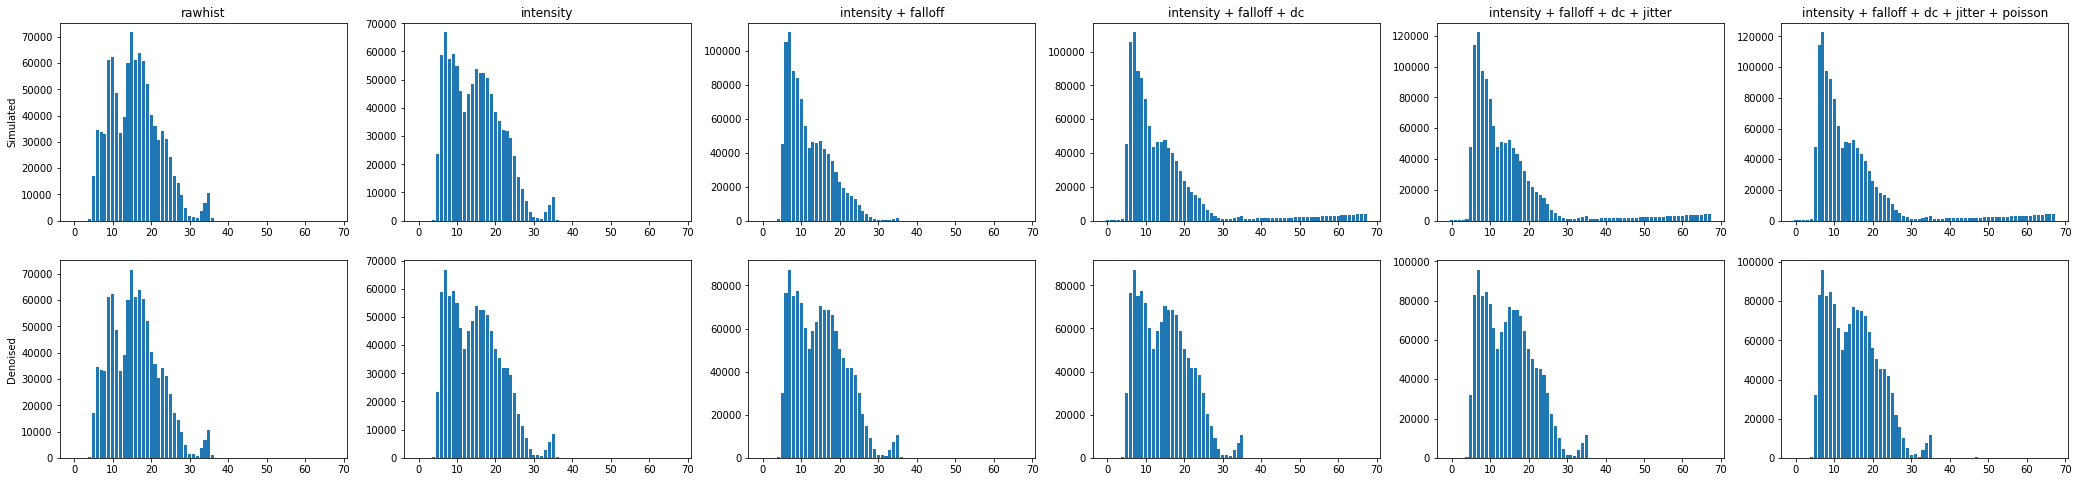

In [118]:
depth = gt
fig, axs = plt.subplots(2, len(spad_types), figsize=(6*len(spad_types), 8))
for i, title in enumerate(spad_types):
    kwargs = spad_types[title]
    spad_sid = simulate_spad_sid(depth, intensity, np.ones_like(depth), min_depth=0., max_depth=10., sid_obj=sid_obj,
                                **kwargs)
    axs[0,i].set_title(title)
    axs[0,i].bar(range(len(spad_sid)), spad_sid)
    denoised_spad_sid = preprocess_spad(spad_sid, sid_obj, kwargs["use_squared_falloff"], kwargs["dc_count"]>0.,
                                        lam=3e2, eps_rel=1e-5)
    axs[1,i].bar(range(len(denoised_spad_sid)), denoised_spad_sid)
axs[0,0].set_ylabel("Simulated")
axs[1,0].set_ylabel("Denoised");

<BarContainer object of 68 artists>

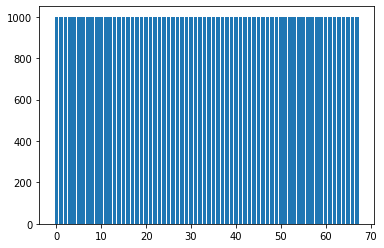

In [40]:
a = np.tile(sid_obj.sid_bin_values[:-2], (100, 10))
a_index = sid_obj.get_sid_index_from_value(a)
a_hist, _ = np.histogram(a_index, bins=range(sid_obj.sid_bins+1))
plt.bar(range(len(a_hist)), a_hist)

<BarContainer object of 68 artists>

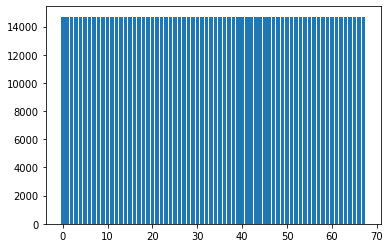

In [41]:
a_spad = simulate_sid_bin_spad(a, np.ones_like(a), np.ones_like(a), 0., 10., sid_obj, 1e6, 0., 70.,
                              False, False, False, False)
plt.bar(range(len(a_spad)), a_spad)

In [42]:
def simulate_sid_bin_spad(depth, intensity, mask, min_depth, max_depth,
                          sid_obj, photon_count, dc_count, fwhm_ps,
                          use_poisson, use_intensity, use_squared_falloff,
                          use_jitter):
    spad_counts = simulate_spad(depth, intensity, mask, min_depth, max_depth,
                                sid_obj.sid_bins, photon_count, dc_count, fwhm_ps,
                                use_poisson, use_intensity, use_squared_falloff,
                                use_jitter)
    spad_sid = rescale_bins(spad_counts, min_depth, max_depth, sid_obj)
    return spad_sid

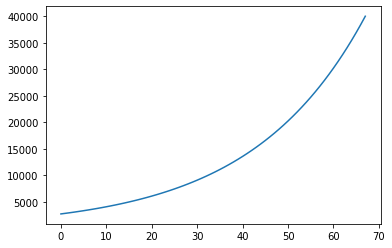

In [19]:
plt.plot(b)